In [1]:
# -*- coding: utf-8 -*-

# Run this code if you get errors with missing requirements
import sys
!{sys.executable} -m pip install mysql-connector
import pandas as pd
import numpy as np
import mysql.connector
mydb = mysql.connector.connect(
  host="iiwari-mariadb-server",
  user="root",
  passwd="d41k4Duu",
  database="iiwari_org")

['.git', 'pic.png', 'lähdekoodi.txt', '.empty', 'docker-compose.yml', '.ipynb_checkpoints', 'README.md', 'iiwari.ipynb', 'init.sql']
0    2
1    3
2    3
3    4
4    5
Name: timestamp, dtype: int64


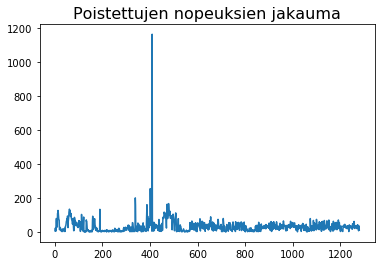

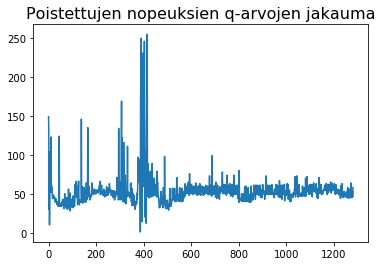

poistettu liian nopean liikkeen takia 1281/76896 pistettä


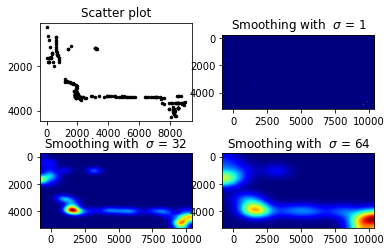

12413
-1.686483167940886
38.90440460111482
0.4364065956344926
55.77683299100096
4769
Poistettujen pisteiden lukumäärä: 57336/76896


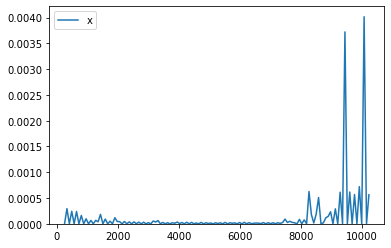

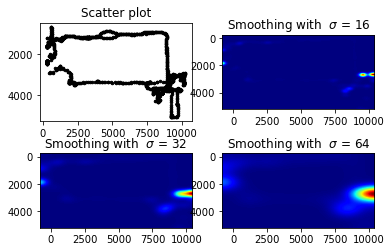

<Figure size 432x288 with 0 Axes>

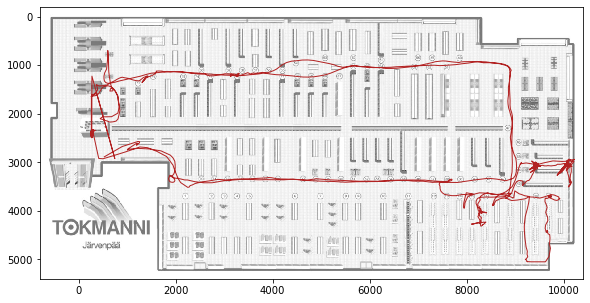

    node_id  COUNT(node_id)
0      3200             259
1      3224              67
2      3240             472
3     51719              71
4     51735            1689
5     51751           17553
6     51850            6528
7     51866           47344
8     51889           55655
9     51968           15732
10    51976           15318
11    51992              25
12    52003            3815
13    52023              24
14    52099           14197
15    52535           34017
16    53011           28839
17    53130           32923
18    53888               1
19    53924             161
20    53936              23
21    54016           27482


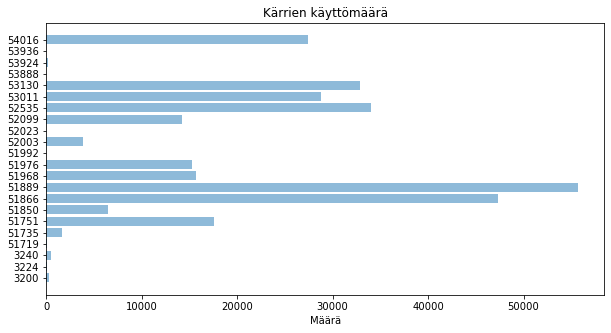

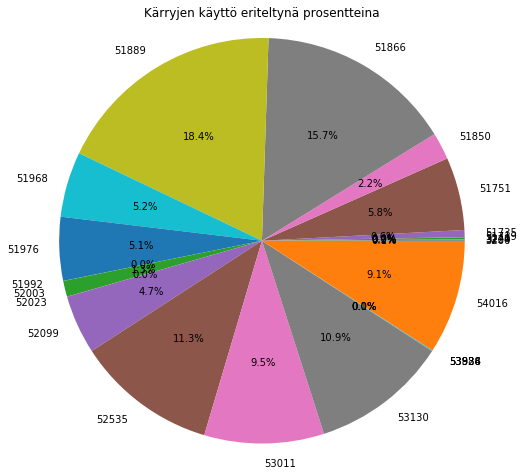

In [2]:
import matplotlib.pyplot as plt

# Hae data tietokannasta SQL-kyselyn avulla
mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT node_id, timestamp, x,y,z,q FROM SensorData WHERE (node_id = 3200) AND timestamp > '2019-07-07 13:05:08.078133+00:00' AND timestamp < '2019-07-08 13:05:08.078133+00:00'  AND x > 0  AND x < 10406 AND y < 5220 AND y > 0 AND z = 0"); # 3200
# 
# SELECT node_id, timestamp, x,y,z,q FROM SensorData WHERE node_id = 3224 AND x > 0  AND x < 10406 AND y < 5220 AND y > 0 LIMIT 100

# Luo tietokannasta haetusta datasta Pandas-kirjaston Dataframe
df = pd.DataFrame(mycursor.fetchall())
df_alkup_koko = df.size

#for i in df:
    #df.drop(df[df.x > 10406].index, inplace=True)
    #df.drop(df[df.y > 5220].index, inplace=True)
    
# Seuraavat kaksi riviä olivat puuttuvan kuvatiedoston etsimistä varten.
import os
print(os.listdir())

import math

import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[-1], xedges[0], yedges[-1], yedges[0]]
    return heatmap.T, extent

df['timestamp'] = df['timestamp'].astype(str)
df['timestamp'] = df['timestamp'].str.slice(2, -7)
df['timestamp'] = df['timestamp'].astype('datetime64[s]')
print(df['timestamp'].dt.second.head())

df2 = df.copy(deep=False)
a = 0
nopeudet = []
koordinaatit = []
q_arvot = []

# Listataan poistettavat koordinaattipisteet taulukoihin, joiden perusteella myöhemmin tehdään kuvaajia.
# Tällä loopilla oli alunperin tarkoitus myös poistaa liian nopeasti liikkuneet pisteet, mutta tämä tyssäsi ValueErroriin.
# Lopulta jouduin käyttämään Antin koodia pisteiden poistamiseen.
for i in range (df.timestamp.size-1):
    ajan_erotus = np.datetime64(df.timestamp[i+1]) - np.datetime64(df.timestamp[i])
    ajan_erotus.item().total_seconds()
    ajan_erotus = ajan_erotus / np.timedelta64(1, 's')
    if ajan_erotus == 0.0:
        continue
    x_erotus = df.x[i+1]-df.x[i]
    y_erotus = df.y[i+1]-df.y[i]
    if (x_erotus / ajan_erotus > 1.5 and y_erotus / ajan_erotus > 1.5):
        #df2.drop(df.index[i], axis = 0, inplace=True)
        temp = []
        temp.append(df.x[i])
        temp.append(df.y[i])
        koordinaatit.append(temp)
        nopeus = math.sqrt((x_erotus / ajan_erotus)**2+(y_erotus / ajan_erotus)**2)
        nopeudet.append(nopeus)
        q_arvot.append(df.q[i])
        a += 1

import seaborn as sns
ax = plt.plot(nopeudet)
plt.title("Poistettujen nopeuksien jakauma", fontsize = 16)
plt.show()

ax = plt.plot(q_arvot)
plt.title("Poistettujen nopeuksien q-arvojen jakauma", fontsize = 16)
plt.show()

print("poistettu liian nopean liikkeen takia "+str(a)+"/"+str(df.size)+" pistettä")

#plt.clf()
#plt.barh(nopeudet, len(nopeudet), align='center', alpha=0.5)
#plt.yticks(nopeudet, nopeudet)
#plt.xlabel('Poistettujen koordinaattipisteiden määrä')
#plt.title('Liian nopeasti liikkuneiden kärryjen nopeudet')
#plt.show()

fig, axs = plt.subplots(2, 2)

df2 = pd.DataFrame(koordinaatit, columns = ['x', 'y'])
df2 = df2.drop(df2[(df2.x < 1000.0) & (df2.y > 2000.0)].index)
df2 = df2.drop(df2[(df2.x > 9000.0)].index)
sigmas = [0, 1, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.invert_yaxis()
        ax.plot(df2.x, df2.y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(df2.x, df2.y, s)
        img = np.flipud(img)
        #ax.imshow(img, extent=extent, origin='upper', cmap=cm.jet)
        ax.imshow(img, extent=[-800, 10400, 5220, -250], origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()

prev = 0
val = 0

def calc_velocity(time_start, time_end):
    #diff_time = time_start - time_end
    diff_time = np.datetime64(time_start) - np.datetime64(time_end)
    diff_time.item().total_seconds()
    diff_time = diff_time / np.timedelta64(1, 's')
    if(diff_time > 0.1):
        return diff_time
    else:
        return 1
x = 0
for i in range(len(df.x)):
   # print(abs(df.iloc[i+1, 3] - abs(df.iloc[i, 3])))
    #print(abs(df.index[i+1]) - abs(df.index[i]))
    if(i < len(df.x)):
        #print(i , " " , x, " ", len(df.x))
        value1 = calc_velocity(df.iloc[i-x, 1], df.iloc[i-(1+x), 1])
        value2 = int((abs(df.iloc[i-x, 2])) - prev)
        val =  value2 / value1
        if (val > 60 or value2 > 100):
            df.drop([df.index[i-x]], axis = 0, inplace = True)
            prev = abs(df.iloc[i-x, 2])
            x +=1
        else:
            prev = abs(df.iloc[i-x, 2])
x = 0
for i in range(len(df.y)):
   # print(abs(df.iloc[i+1, 3] - abs(df.iloc[i, 3])))
    #print(abs(df.index[i+1]) - abs(df.index[i]))
    if(i < len(df.y)):
        value1 = calc_velocity(df.iloc[i-x, 1], df.iloc[i-(1+x), 1])
        value2 = int((abs(df.iloc[i-x, 3]))-prev)
        val = value2 / value1    
        if (val > 60 or value2 > 100):
            df.drop([df.index[i-x]], axis = 0)
            prev = abs(df.iloc[i-x , 3])
            x +=1
        else:
            prev = abs(df.iloc[i-x, 3])
    #print(prev)
    #if (abs(df.iloc[i+1, 3] - abs(df.iloc[i, 3]))) > 400:
        #print("We int")
        
print(len(df.x))
#devx = [df.iloc[i + 1, 2] - df.iloc[i, 2] for i in range(len(df.x)-1)]
devx = []
for i in range(len(df.x)):
    value1 = calc_velocity(df.iloc[i, 1], df.iloc[i-1, 1])
    val = int((abs(df.iloc[i, 2]) - prev)) / value1
    #print(val)
    devx.append(val)
    prev = abs(df.iloc[i, 2])

xmean = np.mean(devx, axis=0)
xsd = np.std(devx, axis=0)
print(xmean)
print(xsd)
i = 0
final_list = [x for x in df.x if (abs(x) > xmean - 0.5 * xsd)]
#final_list = [x for x in final_list if (x < xmean + 0. * xsd)]
for x in final_list:
    if(x < xmean + 6.75 * xsd):
        df.drop([df.index[i]], axis = 0, inplace = True)
        i -= 1
    i += 1
i = 0
#devy = [df.iloc[i + 1, 3] - df.iloc[i, 3] for i in range(len(df.y)-1)]
devy = []
for i in range(len(df.y)):
    value1 = calc_velocity(df.iloc[i, 1], df.iloc[i-1, 1])
    val = int((abs(df.iloc[i, 3]) - prev)) / value1
    #print(val)
    devy.append(val)
    prev = abs(df.iloc[i, 3])
ymean = np.mean(devy, axis=0)
ysd = np.std(devy, axis=0)
print(ymean)
print(ysd)
final_list1 = [y for y in df.y if (abs(y) > ymean - 0.5 * ysd)]
#final_list = [y for y in final_list if (y < ymean + 0.2 * ysd)]
i = 0
print(len(df.y))
for y in final_list1:
    if(y < ymean + 6.75 * ysd):
        df.drop([df.index[i]], axis = 0, inplace = True)
        i -= 1
    i += 1
    

        
        
#for i in range(df.timestamp.size-1):
#    if(df.x[i] < 1850.0 and df.y[i] > 3000.0):
#        df.drop(df.index[i], axis = 0, inplace = True)

df = df.drop(df[(df.x < 1850.0) & (df.y > 3000.0)].index)

df_muokattu_koko = df.size

print("Poistettujen pisteiden lukumäärä: "+str(df_alkup_koko-df_muokattu_koko)+"/"+str(df_alkup_koko))

ax = sns.kdeplot(df.x, bw=.15)


fig, axs = plt.subplots(2, 2)

# Generate some test data
x = df.x
y = df.y
sigmas = [0, 16, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.invert_yaxis()
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        img = np.flipud(img)
        #ax.imshow(img, extent=extent, origin='upper', cmap=cm.jet)
        ax.imshow(img, extent=[-800, 10400, 5220, -250], origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()

plt.clf()
img = plt.imread("pic.png")
plt.rcParams['figure.figsize'] = 10, 5
fig, ax = plt.subplots()
#ax.imshow(img, extent=[0, df.x.max(), 0,df.y.max()])
ax.imshow(img, extent=[-800, 10400, 5400, -200])
#ax.plot(df.x, df.y, '--', linewidth=5, color='firebrick')
ax.plot(df.x, df.y , linewidth=1, color='firebrick')
plt.show()

mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT node_id, COUNT(node_id) FROM SensorData   WHERE timestamp > '2019-05-24 13:05:08.078133+00:00' AND timestamp < '2019-05-25 13:05:08.078133+00:00'  AND x > 0  AND X < 10406 AND y < 5220 AND y > 0 AND   q <100 AND z = 0 GROUP BY node_id") # SELECT DISTINCT node_id FROM SensorData
# SELECT node_id, COUNT(node_id) FROM SensorData   WHERE timestamp > '2019-05-24 13:05:08.078133+00:00' AND timestamp < '2019-05-29 13:05:08.078133+00:00'  AND x > 0  AND X < 10406 AND y < 5220 AND y > 0 AND   q <100 AND z = 0 GROUP BY node_id
nodes = pd.DataFrame(mycursor.fetchall())
print(nodes)

nodes = nodes.rename(columns={'COUNT(node_id)': 'amount'})
objects = nodes.node_id
y_pos = np.arange(len(objects))
performance = nodes.amount

plt.clf()
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Määrä')
plt.title('Kärrien käyttömäärä')
plt.show()

plt.clf()
plt.pie(performance, labels=objects, autopct='%1.1f%%')
plt.axis('equal')
plt.title("Kärryjen käyttö eriteltynä prosentteina")
plt = plt.gcf()
plt.set_size_inches(8,8)
plt.show()

In [47]:
from collections import Counter
def Dublicates(x):
    elements = dict()
    for elem in elements:
        if elem in elements:
            elements[elem] += 1
        else:
            elements[elem] = 1
 
    elements = { key:value for key, value in elements.items() if value > 1}
    return elements

elements = dict(Counter(df.x))

elements = { key:value for key, value in elements.items() if value > 1}
 
for key, value in elements.items():
    #print('x: arvo', key,'esiintyy', value, 'kertaa')

for key, value in elements.items():
    if value > 70:
        value = 1
    #print('x: arvo',key,'esiintyy', value, 'kertaa')

In [68]:
def calc_velocity1(time_start, time_end, ):
    #diff_time = time_start - time_end
    diff_time = np.datetime64(time_start) - np.datetime64(time_end)
    diff_time.item().total_seconds()
    diff_time = diff_time / np.timedelta64(1, 's')
    if(diff_time > 0.1):
        return diff_time
    else:
        return 1
x = 0
import math  
def calculateDistance(x1,y1,x2,y2):  
     dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
     return dist  
devx1 = []
time = []
dist = []
speed = []
i = 1
for i in range(len(df.x)):
    time.append(calc_velocity1(df.iloc[i, 1], df.iloc[i-1, 1]))
    #val = int((abs(df.iloc[i, 2]) - prev)) / value1
    dist.append(calculateDistance(abs(df.iloc[i, 2]), abs(df.iloc[i, 3]),abs(df.iloc[i-1, 2]),  abs(df.iloc[i-1, 3])))
    #print(val)
speed = []
for i in range(len(dist)):
    speed.append((dist[i] / 161)/time[i])
def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t           

    avg = sum_num / len(num)
    return avg
print(cal_average(speed))

0.16481287860549854


[]
HE
[2675, 2693, 2898]
899


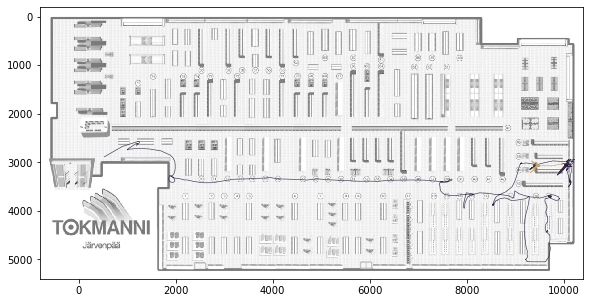

In [29]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
tripEnd =[] 
print(tripEnd)
started = False
bol = False
data = df
for i in range(len(data)):
    #print(data.loc[data.index[i], 'x'],data.loc[data.index[i],'y'])
    if((data.loc[data.index[i], 'x'] > -800.0) & (data.loc[data.index[i],'x'] < 700) & (data.loc[data.index[i],'y'] > 0.0) & (data.loc[data.index[i],'y'] < 2199) &  started):
        tripEnd.append(i)
        #print(started)
        started = False
        #print("end")
    elif(((data.loc[data.index[i], 'x'] > -800.0) & (data.loc[data.index[i],'x'] < 700) & (data.loc[data.index[i],'y'] > 2200) & (data.loc[data.index[i],'y'] < 3100)) & (not started)):
        #print(started)
        started = True
        #print("start")
        
        
        
j1 = 0
for j in tripEnd:
    ax.plot(data.loc[j1:j,'x'],data.loc[j1:j,'y'] , linewidth=1, color=(rnd.randint(0,255),rnd.randint(0,255),rnd.randint(0,255)) )
    j1 = j +1

ax.imshow(img, extent=[-800, 10400, 5400, -200])
plt.show()
print("HE")
print(tripEnd)
print(data.loc[data.index[1], 'x'])
fig, ax = plt.subplots()
prev = 0
ax.imshow(img, extent=[-800, 10400, 5400, -200])
#print(tripEnd)
for j in tripEnd:
    #print(j)
    ax.plot(data.loc[prev:j,'x'],data.loc[prev:j,'y'] , linewidth=0.6, color=np.random.rand(3,) )
    prev = j 

In [66]:
mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT node_id, timestamp, x,y,z,q FROM SensorData WHERE (node_id = 51719)  AND timestamp > '2019-09-24 13:05:08.078133+00:00' AND timestamp < '2019-09-27 13:05:08.078133+00:00'  AND x > 0  AND X < 10406 AND y < 5220 AND y > 0 AND q < 100 AND z = 0 GROUP BY timestamp"); 
times = pd.DataFrame(mycursor.fetchall())
x = np.zeros((3, 4, 5))
np.moveaxis(x, 0, -1).shape
#milestone["only_date"] = [df.date() for df in milestone["datetime"]]
table = pd.DataFrame(columns=list('NTXYZQ'))
table.N = times.node_id
table.T = times.timestamp
table.T2 = times.timestamp
table.T3 = times.timestamp
table.X = times.x
table.Y = times.y
table.Z = times.z
table.Q = times.q
table['T'] = table['T'].astype(str)
#table['T'].dtype
table['T'] = table['T'].str.slice(2, -7)

table['T'] = table['T'].astype('datetime64[ns]')
table['T'] = pd.to_datetime(table['T'], errors='coerce')
table['T'] = pd.Series(table['T']).dt.round("S")
table['T'] = table['T'].dt.date
ts = pd.to_datetime('24/9/2019')
ts2 = pd.to_datetime('27/9/2019')
print(table['T'])
table2 = table.loc[table['T'] >= ts2, :]
#print(table2)

from datetime import date, timedelta
d = 0
dates = []

start_date = date(2019, 10, 1)
end_date = date(2019, 10, 31)
delta = timedelta(days=1)
while start_date <= end_date:
    ts = start_date.strftime("%Y/%m/%d")
    start_date += delta
    d += 1
    dates.append(ts)
for i in dates:
    tsT = table.loc[table['T'] == i, :]
x = tsT.X.tolist()
y = tsT.Y.tolist()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()


0         2019-09-24
1         2019-09-24
2         2019-09-24
3         2019-09-24
4         2019-09-24
             ...    
126539    2019-09-27
126540    2019-09-27
126541    2019-09-27
126542    2019-09-27
126543    2019-09-27
Name: T, Length: 126544, dtype: object


In [18]:
import matplotlib.pyplot as plt
import datetime
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
ulostulo = widgets.Output()

@interact
def nayta_arvot_yli(column1='x', x = 5000, column2='y', y = 2500, column3='timestamp', timestamp='2019-07-07 13:05:08.078133+00:00'):
    def kasittele_tapahtuma(muutos):
        ulostulo.clear_output(wait=True)
        with ulostulo:
            #if muutos['type'] == 'change' and muutos['name'] == 'value':
                #print("changed to %s" % muutos['new'])
            
            #x = np.array([df.drop(df[(df.x < x)].index).x])
            #y = np.array([df.drop(df[(df.y < y)].index).y])
            if muutos['new'] == 'x':
                x1 = np.array([df.loc[df[column1] > x].x])
                y1 = np.array([df.loc[df[column1] > x].y])
                img = plt.imread("pic.png")
                plt.rcParams['figure.figsize'] = 10, 5
                fig, ax = plt.subplots()
                ax.imshow(img, extent=[-800, 10400, 5400, -200])
                ax.plot(x1, y1, 'o') # linewidth=1, color='firebrick'
                plt.show()
            elif muutos['new'] == 'y':
                y2 = np.array([df.loc[df[column2] > y].y])
                x2 = np.array([df.loc[df[column2] > y].x])
                img = plt.imread("pic.png")
                plt.rcParams['figure.figsize'] = 10, 5
                fig, ax = plt.subplots()
                ax.imshow(img, extent=[-800, 10400, 5400, -200])
                ax.plot(x2, y2, 'o')
                plt.show()
            elif muutos['new'] == 'timestamp':
                aika = df.loc[int(df[column3].to_timestamp) > timestamp]
                x3 = np.array([aika.item().total_seconds() > timestamp.item().total_seconds().x])
                y3 = np.array([aika.item().total_seconds() > timestamp.item().total_seconds().y])
                img = plt.imread("pic.png")
                plt.rcParams['figure.figsize'] = 10, 5
                fig, ax = plt.subplots()
                ax.imshow(img, extent=[-800, 10400, 5400, -200])
                ax.plot(x3, y3, 'o')
                plt.show()
        
            #print(x1.size)
            #print(y1.size)
            #return (x1, y1)
        
    valitse_akseli = widgets.Dropdown(
        options=['x', 'y', 'timestamp'],
        value=None,
        description='Akseli:',
    )
    valitse_akseli.observe(kasittele_tapahtuma)
    display(valitse_akseli)
    display(ulostulo)

interactive(children=(Text(value='x', description='column1'), IntSlider(value=5000, description='x', max=15000…